In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('c:\\users\\mmingalov\\geekbrains-recommend-systems\\retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]
data_test

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.00,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.30,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.20,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.00,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.00,112,92,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_probabilities['item_id'])
    probability = np.array(items_probabilities['probability'])
    
    recs = np.random.choice(items, size=n, replace=False, p=probability)
    
    return recs.tolist()

In [5]:
%%time

data = data_train
items_probabilities = data.groupby('item_id')['sales_value'].sum().reset_index()

#комментарий преподавателя:
#как правило эта проблема решается через log(1 + x), в Numpy для этого есть специальная функция np.log1p()
#это также поможет обойти ситуацию с нулевыми продажами

items_probabilities['log'] = np.log1p(items_probabilities['sales_value'])
sum_ = items_probabilities.log.sum()

#probability -- это условная вероятность сэмплирования товара
items_probabilities['probability'] = items_probabilities['log']/sum_.sum()

#сумма по всем товарам д.б. равна единице, проверим
items_probabilities.probability.sum()

Wall time: 862 ms


1.0

In [6]:
weighted_random_recommendation(items_probabilities,5)

[1115006, 13381328, 833648, 6391070, 8159095]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [7]:
def typess(df):
    for j in range(df.shape[1]):
        print(type(df.iloc[0][j]))

In [8]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [9]:
#функция необходима для корректного парсинга CSV -- приводит значения к типу list
def String_to_List(result):
    for i in range(result.shape[0]):
        tt = 'actual'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'random_recommendation'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'popular_recommendation'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'itemitem'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'cosine'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'tfidf'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
        tt = 'own_purchases'
        result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
    


In [10]:
result = pd.read_csv('c:\\users\\mmingalov\\geekbrains-recommend-systems\\predictions_basic.csv')

result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[888210, 9884308, 1163153, 9419753, 996833]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1078063, 881635, 6534085, 13511452, 6533350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [11]:
typess(result)

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [12]:
#видим, что наши списки в CSV лежат в виде строковых значений. Запускаем обработку
String_to_List(result)

<ipython-input-9-503fc4cac26c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
<ipython-input-9-503fc4cac26c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[tt][i] = [int(x) for x in list(result[tt][i].replace('[','').replace(']','').split(', '))]
<ipython-input-9-503fc4cac26c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res

In [13]:
#проверяем результат конвертации в тип данных lis
typess(result)

<class 'numpy.int64'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [14]:
#result['actual'][0]

In [15]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

0.0005876591576885406

In [16]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.15523996082272082

In [17]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.15122428991184922

In [18]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

0.15514201762977264

In [19]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

0.16092066601371002

In [20]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()

0.17969311132876015

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*

In [39]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [40]:
def random_recommendation(items, n):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()
def popularity_recommendation(data, n):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

def weighted_random_recommendation(items_probabilities, n):
    """Случайные рекоммендации
    
    Input
    -----
    items_probabilities: pd.DataFrame
        Датафрейм со столбцами item_id, probability. Сумма probability по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # посмотрите в документации параметр, отвечающий за вероятность сэмплирования
    # your_code

    items = np.array(items_probabilities['item_id'])
    probability = np.array(items_probabilities['probability'])
    
    recs = np.random.choice(items, size=n, replace=False, p=probability)
    
    return recs.tolist()



In [44]:
data = pd.read_csv('c:\\users\\mmingalov\\geekbrains-recommend-systems\\retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [45]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

__добавим то, чего не было в открытом CSV__

In [46]:
data = data_train
items_probabilities = data.groupby('item_id')['sales_value'].sum().reset_index()

#комментарий преподавателя:
#как правило эта проблема решается через log(1 + x), в Numpy для этого есть специальная функция np.log1p()
#это также поможет обойти ситуацию с нулевыми продажами

items_probabilities['log'] = np.log1p(items_probabilities['sales_value'])
sum_ = items_probabilities.log.sum()

#probability -- это условная вероятность сэмплирования товара
items_probabilities['probability'] = items_probabilities['log']/sum_.sum()

#сумма по всем товарам д.б. равна единице, проверим
items_probabilities.probability.sum()
result['weighted_random_recommendation'] = result['user_id'].apply(\
                                                            lambda x: weighted_random_recommendation(items_probabilities,5))

In [47]:
#ФОРМИРУЕМвсе товары, отсортированные по популярности
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.sort_values('sales_value', ascending=False, inplace=True)

In [82]:
n_list = [2000,5000,10000]

In [48]:
#посчитамем BASELINES под разные N популярноси
for item, value in enumerate(n_list):
    
    data_n = popularity[:value]
    
    #RANDOM
    result['random_recommendation'+ str(value)] = result['user_id'].apply(lambda x: random_recommendation(data_n.item_id.tolist(), n=5))

    #POPULAR
    result['popular_recommendation'+ str(value)] = result['user_id'].apply(lambda x: popularity_recommendation(data_n, 5))

    #WEIGHTED_RANDOM
    #popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    items_probabilities = data_n.groupby('item_id')['sales_value'].sum().reset_index()
    items_probabilities['log'] = np.log1p(items_probabilities['sales_value'])
    sum_ = items_probabilities.log.sum()
    #probability -- это условная вероятность сэмплирования товара
    items_probabilities['probability'] = items_probabilities['log']/sum_.sum()
    #сумма по всем товарам д.б. равна единице, проверим
    print(items_probabilities.probability.sum(), ' -- проверка на 1')
    
    result['weighted_random_recommendation'+ str(value)] = result['user_id'].apply(\
                                                            lambda x: weighted_random_recommendation(items_probabilities,5))

1.0  -- проверка на 1
1.0  -- проверка на 1
1.0  -- проверка на 1


## Посчитаем precision_at_k и визуализируем на графике

In [90]:
#для графиков понадобятся labels
n_list = [2000,5000,10000]
TotalID = data_train.item_id.nunique()
n_list.append(TotalID)

labels = [str(x) for x in (n_list)]
print(labels)
#print(labels.append(3))

['2000', '5000', '10000', '86865']


In [49]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation2000,popular_recommendation2000,weighted_random_recommendation2000,random_recommendation5000,popular_recommendation5000,weighted_random_recommendation5000,random_recommendation10000,popular_recommendation10000,weighted_random_recommendation10000,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[888210, 9884308, 1163153, 9419753, 996833]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[999999, 1082185, 1029743, 995785, 1004906]","[1015247, 1092878, 1134398, 961979, 1135552]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1119761, 1041259, 5569230, 1116096, 8014645]","[1036297, 1017363, 1132619, 905636, 881594]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1118012, 873887, 1051211, 1087755, 1023160]","[953320, 917387, 970119, 12599756, 1111035]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1045914, 1025435, 984250, 1077285, 5981072]","[5566648, 902336, 1223797, 995134, 971896]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1078063, 881635, 6534085, 13511452, 6533350]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[999999, 1082185, 1098066, 6534178, 1127831]","[1005609, 898043, 854852, 1134483, 843898]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1127624, 863447, 898847, 1077555, 1112205]","[1096635, 1053489, 1108994, 1045109, 1099905]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1050229, 822225, 1014948, 1012701, 12349795]","[13776705, 907099, 1817725, 991223, 13002975]","[6534178, 6533889, 1029743, 6534166, 1082185]","[902811, 1023546, 12604332, 6463772, 1034383]","[948150, 1082124, 13911642, 6423948, 973679]"


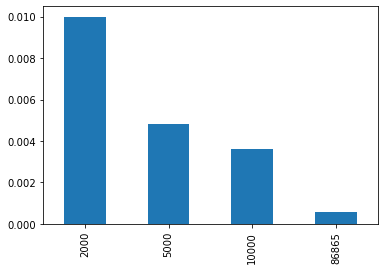

In [86]:
values_N = [
    result.apply(lambda row: precision_at_k(row['random_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation10000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()
]

plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

## получилим максимальный результат на выборке из 2000 популярных товаров. На мой взгляд ожидаемо, поскольку чем больше выборка популярных товаров, тем меньше шансов, что множество ACTUAL юзера пересеклось с RANDOM_RECOMMENDATION  выборкой

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


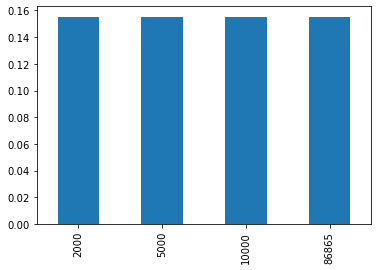

In [87]:
values_N = [
    result.apply(lambda row: precision_at_k(row['popular_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation10000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()
]


plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

## метрика по популярным товарам будет одинаковой для всех размеров топ-выборки, так как ВСЕГДА берем первых 5

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


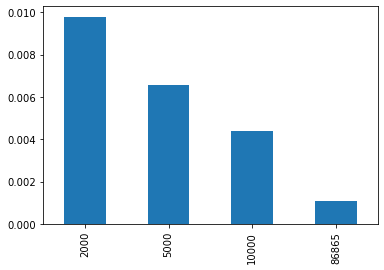

In [91]:
values_N = [
    result.apply(lambda row: precision_at_k(row['weighted_random_recommendation2000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation5000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation10000'], row['actual']), axis=1).mean()
    ,result.apply(lambda row: precision_at_k(row['weighted_random_recommendation'], row['actual']), axis=1).mean()
]

plt_data = pd.Series(values_N, index= labels)
plt_data.plot(kind="bar")

In [92]:

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=labels, values=values_N)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [94]:
popularity_q = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity_q.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity_q.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.shape

(2499, 5001)

In [95]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [96]:
# K=1 - это own_purchases, посчитаем для K от 2 до 7, кроме K=5 (это столбец itemitem)
model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem2'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [97]:
model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem3'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [98]:
model = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem4'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [99]:
model = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem6'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [100]:
model = ItemItemRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem7'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [101]:
y2 = result.apply(lambda row: precision_at_k(row['itemitem2'], row['actual']), axis=1).mean()
y2

0.059786157362063795

In [102]:
y3 = result.apply(lambda row: precision_at_k(row['itemitem3'], row['actual']), axis=1).mean()
y3

0.05847208619001024

In [103]:
y4 = result.apply(lambda row: precision_at_k(row['itemitem4'], row['actual']), axis=1).mean()
y4

0.0412340842311462

In [104]:
y5 = result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()
y5

0.15122428991184922

In [105]:
y6 = result.apply(lambda row: precision_at_k(row['itemitem6'], row['actual']), axis=1).mean()
y6

0.031929480901077514

In [106]:
y7 = result.apply(lambda row: precision_at_k(row['itemitem7'], row['actual']), axis=1).mean()
y7

0.03143976493633706

In [107]:
x = [K for K in range(2, 8)]
y = [y2, y3, y4, y5, y6, y7]

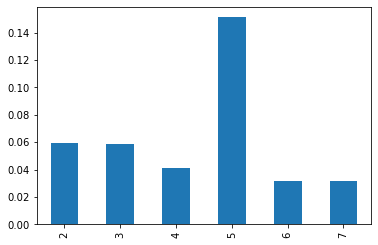

In [108]:
plt_data = pd.Series(y, index= x)
plt_data.plot(kind="bar")

__результат не совсем понятный. из него выходит, что K=5 оптимальное число соседей, а прочие варианты отличаются значительно__